In [1]:
import os
import pandas as pd
import numpy as np
import joblib
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [2]:
# get all the image paths
image_paths = list(paths.list_images('input/Images'))
# create an empty DataFrame
data = pd.DataFrame()
labels = []
for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
    label = image_path.split(os.path.sep)[-2]
    data.loc[i, 'image_path'] = image_path
    labels.append(label)
    
labels = np.array(labels)
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

print(f"The first one hot encoded labels: {labels[0]}")
print(f"Mapping an one hot encoded label to its category: {lb.classes_[0]}")
print(f"Total instances: {len(labels)}")
for i in range(len(labels)):
    index = np.argmax(labels[i])
    #index = labels[i]

    data.loc[i, 'target'] = int(index)
# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)
# save as csv file
data.to_csv('input/data.csv', index=False)
# pickle the label binarizer
joblib.dump(lb, 'output/lb.pkl')
print('Save the one-hot encoded binarized labels as a pickled file.')
print(data.head())

100%|██████████| 656/656 [00:00<00:00, 6239.80it/s]

The first one hot encoded labels: [1 0 0 0 0 0 0 0 0 0 0]
Mapping an one hot encoded label to its category: cbf
Total instances: 656
Save the one-hot encoded binarized labels as a pickled file.
                      image_path  target
0  input/Images\cmcf\cmcf_15.jpg     4.0
1    input/Images\ccf\ccf_11.jpg     1.0
2  input/Images\omcf\omcf_25.jpg     9.0
3  input/Images\cmbf\cmbf_47.jpg     3.0
4    input/Images\obf\obf_17.jpg     6.0


In [3]:
import pandas as pd
import joblib
import numpy as np
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [4]:
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cpu


In [5]:
# construct the argument parser and parse the arguments
parser = argparse.ArgumentParser()
parser.add_argument('-e', '--epochs', default=200, type=int,
    help='number of epochs to train the model for')
#args = vars(parser.parse_args())
args, unknown = parser.parse_known_args()
args = vars(args)

In [6]:
# read the data.csv file and get the image paths and labels
df = pd.read_csv('input/data.csv')
X = df.image_path.values
y = df.target.values

In [7]:
(xtrain, xtest, ytrain, ytest) = (train_test_split(X, y, 
                                test_size=0.25, random_state=42))


In [8]:
# image dataset module
class NaturalImageDataset(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            
            self.aug = albumentations.Compose([
                albumentations.Resize(72, 72, always_apply=True),
                albumentations.Normalize(mean=[0, 0, 0],
                          std=[1, 1, 1], always_apply=True)
                #albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                #          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
            '''
            self.aug = albumentations.Compose([
                albumentations.Resize(72, 72, always_apply=True)
            ])
            '''
        else: # if training
            
            self.aug = albumentations.Compose([
                albumentations.Resize(72, 72, always_apply=True),
                albumentations.Normalize(mean=[0, 0, 0],
                          std=[1, 1, 1], always_apply=True)
                #albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                #          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
            '''
            self.aug = albumentations.Compose([
                albumentations.Resize(72, 72, always_apply=True)
            ])
            '''
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [9]:
train_data = NaturalImageDataset(xtrain, ytrain, tfms=1)
test_data = NaturalImageDataset(xtest, ytest, tfms=0)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
testloader = DataLoader(test_data, batch_size=16, shuffle=False)

Feature Batch Shape: torch.Size([16, 3, 72, 72])
Label Batch Shape: torch.Size([16])


<ipython-input-8-e84cceec4aa6>:43: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)


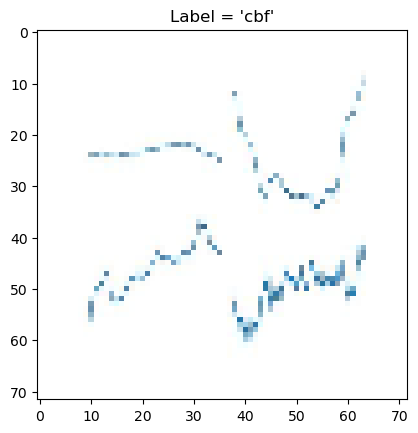

Labels: [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [10]:
vows = ['cbf', 'ccf', 'cff', 'cmbf', 'cmcf', 'cmff', 'obf', 'off', 'ombf', 'omcf', 'omff']

trainfeature, trainlabel = next(iter(trainloader))
print(f"Feature Batch Shape: {trainfeature.size()}")
print(f"Label Batch Shape: {trainlabel.size()}")
imgdir = np.transpose(trainfeature[0].squeeze(), (1,2,0))
plt.imshow(imgdir, cmap="gray")
plt.title("Label = '{}'".format(vows[np.array(trainlabel)[0]]))
plt.show()
print(f"Labels: {labels}")

In [11]:
# load the binarized labels
print('Loading label binarizer...')
lb = joblib.load('output/lb.pkl')

Loading label binarizer...


In [12]:
def model(pretrained, requires_grad):
    model = models.alexnet(progress=True, pretrained=pretrained)
    
    # freeze hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    '''
    model.fc = nn.Sequential(
        nn.Linear(2048, 1024),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(1024, 256),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(256, 11),
    )
    '''
    return model
model = model(pretrained=True, requires_grad=False).to(device)
print(model)

c:\Users\ikeryu\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ikeryu\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
model.classifier[1] = nn.Linear(9216,4096)
model.classifier[4] = nn.Linear(4096,1024)
model.classifier[6] = nn.Linear(1024,11)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
# optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0005)
# loss function
criterion = nn.CrossEntropyLoss()

In [15]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(test_dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [16]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [17]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(args['epochs']):
    print(f"Epoch {epoch+1} of {args['epochs']}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

Epoch 1 of 200
Training


  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-8-e84cceec4aa6>:43: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)
31it [00:06,  4.90it/s]                        


Train Loss: 0.1512, Train Acc: 10.98
Validating


11it [00:00, 28.92it/s]                       


Val Loss: 0.1595, Val Acc: 10.37
Epoch 2 of 200
Training


31it [00:06,  5.07it/s]                        


Train Loss: 0.1505, Train Acc: 11.18
Validating


11it [00:00, 29.92it/s]                       


Val Loss: 0.1588, Val Acc: 7.32
Epoch 3 of 200
Training


31it [00:06,  5.12it/s]                        


Train Loss: 0.1497, Train Acc: 11.59
Validating


11it [00:00, 31.80it/s]                       


Val Loss: 0.1582, Val Acc: 12.20
Epoch 4 of 200
Training


31it [00:06,  4.71it/s]                        


Train Loss: 0.1482, Train Acc: 11.99
Validating


11it [00:00, 28.15it/s]                       


Val Loss: 0.1568, Val Acc: 12.20
Epoch 5 of 200
Training


31it [00:07,  3.89it/s]                        


Train Loss: 0.1477, Train Acc: 11.99
Validating


11it [00:00, 24.62it/s]                       


Val Loss: 0.1559, Val Acc: 10.98
Epoch 6 of 200
Training


31it [00:06,  4.89it/s]                        


Train Loss: 0.1477, Train Acc: 12.80
Validating


11it [00:00, 31.39it/s]                       


Val Loss: 0.1547, Val Acc: 12.80
Epoch 7 of 200
Training


31it [00:06,  4.99it/s]                        


Train Loss: 0.1465, Train Acc: 13.21
Validating


11it [00:00, 26.91it/s]                       


Val Loss: 0.1533, Val Acc: 24.39
Epoch 8 of 200
Training


31it [00:06,  4.96it/s]                        


Train Loss: 0.1453, Train Acc: 16.67
Validating


11it [00:00, 26.58it/s]                       


Val Loss: 0.1524, Val Acc: 17.68
Epoch 9 of 200
Training


31it [00:06,  4.80it/s]                        


Train Loss: 0.1450, Train Acc: 16.67
Validating


11it [00:00, 30.89it/s]                       


Val Loss: 0.1508, Val Acc: 29.27
Epoch 10 of 200
Training


31it [00:06,  4.95it/s]                        


Train Loss: 0.1435, Train Acc: 20.53
Validating


11it [00:00, 28.76it/s]                        


Val Loss: 0.1499, Val Acc: 26.83
Epoch 11 of 200
Training


31it [00:06,  4.83it/s]                        


Train Loss: 0.1421, Train Acc: 20.33
Validating


11it [00:00, 29.52it/s]                       


Val Loss: 0.1484, Val Acc: 29.27
Epoch 12 of 200
Training


31it [00:06,  4.82it/s]                        


Train Loss: 0.1431, Train Acc: 18.90
Validating


11it [00:00, 29.69it/s]                        


Val Loss: 0.1473, Val Acc: 32.32
Epoch 13 of 200
Training


31it [00:06,  4.71it/s]                        


Train Loss: 0.1413, Train Acc: 21.34
Validating


11it [00:00, 29.18it/s]                        


Val Loss: 0.1460, Val Acc: 32.32
Epoch 14 of 200
Training


31it [00:06,  4.85it/s]                        


Train Loss: 0.1397, Train Acc: 27.44
Validating


11it [00:00, 31.08it/s]                       


Val Loss: 0.1446, Val Acc: 34.76
Epoch 15 of 200
Training


31it [00:06,  4.84it/s]                        


Train Loss: 0.1395, Train Acc: 22.76
Validating


11it [00:00, 29.77it/s]                        


Val Loss: 0.1432, Val Acc: 42.68
Epoch 16 of 200
Training


31it [00:06,  4.87it/s]                        


Train Loss: 0.1384, Train Acc: 28.05
Validating


11it [00:00, 30.91it/s]                       


Val Loss: 0.1417, Val Acc: 40.24
Epoch 17 of 200
Training


31it [00:06,  4.88it/s]                        


Train Loss: 0.1365, Train Acc: 30.28
Validating


11it [00:00, 30.56it/s]                       


Val Loss: 0.1401, Val Acc: 40.85
Epoch 18 of 200
Training


31it [00:06,  4.95it/s]                        


Train Loss: 0.1361, Train Acc: 29.67
Validating


11it [00:00, 30.86it/s]                       


Val Loss: 0.1384, Val Acc: 45.73
Epoch 19 of 200
Training


31it [00:06,  4.97it/s]                        


Train Loss: 0.1353, Train Acc: 31.30
Validating


11it [00:00, 30.24it/s]                       


Val Loss: 0.1370, Val Acc: 46.95
Epoch 20 of 200
Training


31it [00:06,  4.93it/s]                        


Train Loss: 0.1339, Train Acc: 33.54
Validating


11it [00:00, 30.63it/s]                       


Val Loss: 0.1356, Val Acc: 45.12
Epoch 21 of 200
Training


31it [00:06,  4.84it/s]                        


Train Loss: 0.1317, Train Acc: 31.50
Validating


11it [00:00, 29.71it/s]                       


Val Loss: 0.1336, Val Acc: 51.83
Epoch 22 of 200
Training


31it [00:06,  4.92it/s]                        


Train Loss: 0.1308, Train Acc: 34.96
Validating


11it [00:00, 29.61it/s]                        


Val Loss: 0.1322, Val Acc: 50.00
Epoch 23 of 200
Training


31it [00:06,  5.00it/s]                        


Train Loss: 0.1304, Train Acc: 33.54
Validating


11it [00:00, 30.74it/s]                       


Val Loss: 0.1302, Val Acc: 50.00
Epoch 24 of 200
Training


31it [00:06,  4.90it/s]                        


Train Loss: 0.1289, Train Acc: 34.76
Validating


11it [00:00, 28.33it/s]                       


Val Loss: 0.1284, Val Acc: 51.83
Epoch 25 of 200
Training


31it [00:06,  4.90it/s]                        


Train Loss: 0.1273, Train Acc: 33.13
Validating


11it [00:00, 30.79it/s]                       


Val Loss: 0.1269, Val Acc: 51.22
Epoch 26 of 200
Training


31it [00:06,  4.90it/s]                        


Train Loss: 0.1247, Train Acc: 40.24
Validating


11it [00:00, 28.98it/s]                        


Val Loss: 0.1252, Val Acc: 50.61
Epoch 27 of 200
Training


31it [00:06,  4.87it/s]                        


Train Loss: 0.1245, Train Acc: 37.20
Validating


11it [00:00, 30.44it/s]                       


Val Loss: 0.1234, Val Acc: 48.78
Epoch 28 of 200
Training


31it [00:06,  4.85it/s]                        


Train Loss: 0.1220, Train Acc: 40.04
Validating


11it [00:00, 29.30it/s]                       


Val Loss: 0.1215, Val Acc: 52.44
Epoch 29 of 200
Training


31it [00:06,  4.97it/s]                        


Train Loss: 0.1210, Train Acc: 39.63
Validating


11it [00:00, 31.31it/s]                       


Val Loss: 0.1197, Val Acc: 53.66
Epoch 30 of 200
Training


31it [00:06,  4.93it/s]                        


Train Loss: 0.1202, Train Acc: 40.45
Validating


11it [00:00, 31.03it/s]                       


Val Loss: 0.1182, Val Acc: 49.39
Epoch 31 of 200
Training


31it [00:06,  4.88it/s]                        


Train Loss: 0.1190, Train Acc: 40.45
Validating


11it [00:00, 30.35it/s]                       


Val Loss: 0.1165, Val Acc: 52.44
Epoch 32 of 200
Training


31it [00:06,  4.94it/s]                        


Train Loss: 0.1158, Train Acc: 44.51
Validating


11it [00:00, 30.99it/s]                       


Val Loss: 0.1142, Val Acc: 54.88
Epoch 33 of 200
Training


31it [00:06,  4.97it/s]                        


Train Loss: 0.1169, Train Acc: 40.24
Validating


11it [00:00, 30.79it/s]                       


Val Loss: 0.1127, Val Acc: 53.66
Epoch 34 of 200
Training


31it [00:06,  5.00it/s]                        


Train Loss: 0.1144, Train Acc: 43.29
Validating


11it [00:00, 30.05it/s]                       


Val Loss: 0.1115, Val Acc: 51.83
Epoch 35 of 200
Training


31it [00:06,  5.00it/s]                        


Train Loss: 0.1125, Train Acc: 46.95
Validating


11it [00:00, 30.82it/s]                       


Val Loss: 0.1096, Val Acc: 54.88
Epoch 36 of 200
Training


31it [00:06,  4.96it/s]                        


Train Loss: 0.1119, Train Acc: 42.48
Validating


11it [00:00, 31.43it/s]                       


Val Loss: 0.1087, Val Acc: 52.44
Epoch 37 of 200
Training


31it [00:06,  4.80it/s]                        


Train Loss: 0.1110, Train Acc: 45.33
Validating


11it [00:00, 29.87it/s]                       


Val Loss: 0.1072, Val Acc: 53.05
Epoch 38 of 200
Training


31it [00:06,  4.76it/s]                        


Train Loss: 0.1100, Train Acc: 43.70
Validating


11it [00:00, 28.52it/s]                       


Val Loss: 0.1062, Val Acc: 56.10
Epoch 39 of 200
Training


31it [00:06,  5.00it/s]                        


Train Loss: 0.1078, Train Acc: 45.12
Validating


11it [00:00, 31.12it/s]                       


Val Loss: 0.1039, Val Acc: 55.49
Epoch 40 of 200
Training


31it [00:06,  4.99it/s]                        


Train Loss: 0.1080, Train Acc: 47.97
Validating


11it [00:00, 30.56it/s]                       


Val Loss: 0.1035, Val Acc: 54.88
Epoch 41 of 200
Training


31it [00:06,  4.96it/s]                        


Train Loss: 0.1059, Train Acc: 47.15
Validating


11it [00:00, 30.37it/s]                       


Val Loss: 0.1018, Val Acc: 54.88
Epoch 42 of 200
Training


31it [00:06,  4.99it/s]                        


Train Loss: 0.1037, Train Acc: 50.61
Validating


11it [00:00, 27.70it/s]                        


Val Loss: 0.1009, Val Acc: 54.88
Epoch 43 of 200
Training


31it [00:06,  4.96it/s]                        


Train Loss: 0.1036, Train Acc: 48.17
Validating


11it [00:00, 30.89it/s]                       


Val Loss: 0.0989, Val Acc: 58.54
Epoch 44 of 200
Training


31it [00:06,  4.95it/s]                        


Train Loss: 0.1037, Train Acc: 49.19
Validating


11it [00:00, 30.41it/s]                       


Val Loss: 0.0972, Val Acc: 57.32
Epoch 45 of 200
Training


31it [00:06,  5.03it/s]                        


Train Loss: 0.1009, Train Acc: 48.37
Validating


11it [00:00, 30.21it/s]                       


Val Loss: 0.0977, Val Acc: 53.05
Epoch 46 of 200
Training


31it [00:06,  4.96it/s]                        


Train Loss: 0.1007, Train Acc: 43.90
Validating


11it [00:00, 29.96it/s]                       


Val Loss: 0.0959, Val Acc: 56.71
Epoch 47 of 200
Training


31it [00:06,  5.01it/s]                        


Train Loss: 0.0992, Train Acc: 48.78
Validating


11it [00:00, 29.72it/s]                       


Val Loss: 0.0951, Val Acc: 57.93
Epoch 48 of 200
Training


31it [00:06,  4.97it/s]                        


Train Loss: 0.0994, Train Acc: 49.19
Validating


11it [00:00, 28.45it/s]                        


Val Loss: 0.0950, Val Acc: 55.49
Epoch 49 of 200
Training


31it [00:06,  4.87it/s]                        


Train Loss: 0.0981, Train Acc: 50.81
Validating


11it [00:00, 30.35it/s]                       


Val Loss: 0.0917, Val Acc: 59.15
Epoch 50 of 200
Training


31it [00:06,  4.88it/s]                        


Train Loss: 0.0959, Train Acc: 50.61
Validating


11it [00:00, 30.37it/s]                       


Val Loss: 0.0913, Val Acc: 59.15
Epoch 51 of 200
Training


31it [00:06,  4.93it/s]                        


Train Loss: 0.0964, Train Acc: 50.00
Validating


11it [00:00, 30.53it/s]                       


Val Loss: 0.0895, Val Acc: 61.59
Epoch 52 of 200
Training


31it [00:06,  4.85it/s]                        


Train Loss: 0.0931, Train Acc: 52.64
Validating


11it [00:00, 29.43it/s]                        


Val Loss: 0.0892, Val Acc: 60.37
Epoch 53 of 200
Training


31it [00:06,  4.94it/s]                        


Train Loss: 0.0953, Train Acc: 50.81
Validating


11it [00:00, 29.77it/s]                       


Val Loss: 0.0890, Val Acc: 60.37
Epoch 54 of 200
Training


31it [00:06,  4.97it/s]                        


Train Loss: 0.0921, Train Acc: 52.44
Validating


11it [00:00, 31.01it/s]                       


Val Loss: 0.0882, Val Acc: 59.15
Epoch 55 of 200
Training


31it [00:06,  4.93it/s]                        


Train Loss: 0.0900, Train Acc: 54.67
Validating


11it [00:00, 30.70it/s]                       


Val Loss: 0.0887, Val Acc: 56.71
Epoch 56 of 200
Training


31it [00:06,  4.99it/s]                        


Train Loss: 0.0910, Train Acc: 49.59
Validating


11it [00:00, 30.59it/s]                       


Val Loss: 0.0846, Val Acc: 60.37
Epoch 57 of 200
Training


31it [00:06,  4.84it/s]                        


Train Loss: 0.0907, Train Acc: 55.08
Validating


11it [00:00, 29.01it/s]                        


Val Loss: 0.0847, Val Acc: 62.80
Epoch 58 of 200
Training


31it [00:06,  4.95it/s]                        


Train Loss: 0.0901, Train Acc: 52.03
Validating


11it [00:00, 30.35it/s]                       


Val Loss: 0.0835, Val Acc: 60.37
Epoch 59 of 200
Training


31it [00:06,  4.97it/s]                        


Train Loss: 0.0879, Train Acc: 52.85
Validating


11it [00:00, 30.45it/s]                       


Val Loss: 0.0839, Val Acc: 57.32
Epoch 60 of 200
Training


31it [00:06,  4.92it/s]                        


Train Loss: 0.0877, Train Acc: 53.66
Validating


11it [00:00, 29.52it/s]                       


Val Loss: 0.0822, Val Acc: 61.59
Epoch 61 of 200
Training


31it [00:06,  4.97it/s]                        


Train Loss: 0.0868, Train Acc: 53.86
Validating


11it [00:00, 30.22it/s]                       


Val Loss: 0.0835, Val Acc: 60.98
Epoch 62 of 200
Training


31it [00:06,  4.94it/s]                        


Train Loss: 0.0874, Train Acc: 54.07
Validating


11it [00:00, 28.95it/s]                       


Val Loss: 0.0820, Val Acc: 60.37
Epoch 63 of 200
Training


31it [00:06,  4.90it/s]                        


Train Loss: 0.0865, Train Acc: 56.30
Validating


11it [00:00, 31.15it/s]                       


Val Loss: 0.0809, Val Acc: 65.24
Epoch 64 of 200
Training


31it [00:06,  4.99it/s]                        


Train Loss: 0.0842, Train Acc: 56.10
Validating


11it [00:00, 30.88it/s]                       


Val Loss: 0.0812, Val Acc: 61.59
Epoch 65 of 200
Training


31it [00:06,  5.01it/s]                        


Train Loss: 0.0860, Train Acc: 54.07
Validating


11it [00:00, 30.94it/s]                       


Val Loss: 0.0818, Val Acc: 62.20
Epoch 66 of 200
Training


31it [00:06,  5.04it/s]                        


Train Loss: 0.0844, Train Acc: 55.69
Validating


11it [00:00, 30.78it/s]                       


Val Loss: 0.0805, Val Acc: 59.76
Epoch 67 of 200
Training


31it [00:06,  5.00it/s]                        


Train Loss: 0.0841, Train Acc: 53.25
Validating


11it [00:00, 30.80it/s]                       


Val Loss: 0.0796, Val Acc: 56.71
Epoch 68 of 200
Training


31it [00:06,  5.03it/s]                        


Train Loss: 0.0829, Train Acc: 56.50
Validating


11it [00:00, 30.76it/s]                       


Val Loss: 0.0776, Val Acc: 62.80
Epoch 69 of 200
Training


31it [00:06,  5.00it/s]                        


Train Loss: 0.0837, Train Acc: 56.30
Validating


11it [00:00, 30.08it/s]                        


Val Loss: 0.0780, Val Acc: 58.54
Epoch 70 of 200
Training


31it [00:06,  5.06it/s]                        


Train Loss: 0.0823, Train Acc: 57.32
Validating


11it [00:00, 30.56it/s]                       


Val Loss: 0.0766, Val Acc: 63.41
Epoch 71 of 200
Training


31it [00:06,  5.00it/s]                        


Train Loss: 0.0805, Train Acc: 57.32
Validating


11it [00:00, 30.62it/s]                       


Val Loss: 0.0771, Val Acc: 59.76
Epoch 72 of 200
Training


31it [00:06,  5.04it/s]                        


Train Loss: 0.0831, Train Acc: 55.89
Validating


11it [00:00, 30.06it/s]                       


Val Loss: 0.0759, Val Acc: 60.37
Epoch 73 of 200
Training


31it [00:06,  5.01it/s]                        


Train Loss: 0.0806, Train Acc: 58.54
Validating


11it [00:00, 29.93it/s]                       


Val Loss: 0.0779, Val Acc: 59.15
Epoch 74 of 200
Training


31it [00:06,  5.03it/s]                        


Train Loss: 0.0811, Train Acc: 59.15
Validating


11it [00:00, 30.53it/s]                       


Val Loss: 0.0738, Val Acc: 64.63
Epoch 75 of 200
Training


31it [00:06,  4.97it/s]                        


Train Loss: 0.0804, Train Acc: 60.37
Validating


11it [00:00, 30.34it/s]                       


Val Loss: 0.0734, Val Acc: 62.20
Epoch 76 of 200
Training


31it [00:06,  4.93it/s]                        


Train Loss: 0.0795, Train Acc: 55.89
Validating


11it [00:00, 29.41it/s]                        


Val Loss: 0.0732, Val Acc: 63.41
Epoch 77 of 200
Training


31it [00:06,  4.77it/s]                        


Train Loss: 0.0796, Train Acc: 57.93
Validating


11it [00:00, 29.60it/s]                       


Val Loss: 0.0749, Val Acc: 59.76
Epoch 78 of 200
Training


31it [00:06,  4.81it/s]                        


Train Loss: 0.0791, Train Acc: 58.94
Validating


11it [00:00, 27.94it/s]                       


Val Loss: 0.0734, Val Acc: 63.41
Epoch 79 of 200
Training


31it [00:06,  4.88it/s]                        


Train Loss: 0.0774, Train Acc: 58.94
Validating


11it [00:00, 30.85it/s]                       


Val Loss: 0.0729, Val Acc: 60.98
Epoch 80 of 200
Training


31it [00:06,  4.99it/s]                        


Train Loss: 0.0777, Train Acc: 58.33
Validating


11it [00:00, 29.31it/s]                       


Val Loss: 0.0702, Val Acc: 65.24
Epoch 81 of 200
Training


31it [00:06,  5.02it/s]                        


Train Loss: 0.0773, Train Acc: 58.54
Validating


11it [00:00, 30.48it/s]                       


Val Loss: 0.0705, Val Acc: 64.63
Epoch 82 of 200
Training


31it [00:06,  5.03it/s]                        


Train Loss: 0.0761, Train Acc: 61.18
Validating


11it [00:00, 30.01it/s]                       


Val Loss: 0.0707, Val Acc: 62.80
Epoch 83 of 200
Training


31it [00:06,  4.98it/s]                        


Train Loss: 0.0760, Train Acc: 59.76
Validating


11it [00:00, 31.07it/s]                       


Val Loss: 0.0699, Val Acc: 67.68
Epoch 84 of 200
Training


31it [00:06,  5.05it/s]                        


Train Loss: 0.0750, Train Acc: 56.71
Validating


11it [00:00, 29.68it/s]                        


Val Loss: 0.0717, Val Acc: 59.76
Epoch 85 of 200
Training


31it [00:06,  4.94it/s]                        


Train Loss: 0.0761, Train Acc: 56.71
Validating


11it [00:00, 29.73it/s]                       


Val Loss: 0.0709, Val Acc: 65.24
Epoch 86 of 200
Training


31it [00:06,  4.86it/s]                        


Train Loss: 0.0744, Train Acc: 60.98
Validating


11it [00:00, 30.07it/s]                       


Val Loss: 0.0716, Val Acc: 64.02
Epoch 87 of 200
Training


31it [00:06,  4.98it/s]                        


Train Loss: 0.0739, Train Acc: 59.55
Validating


11it [00:00, 29.69it/s]                       


Val Loss: 0.0699, Val Acc: 65.85
Epoch 88 of 200
Training


31it [00:06,  5.03it/s]                        


Train Loss: 0.0753, Train Acc: 57.11
Validating


11it [00:00, 31.22it/s]                       


Val Loss: 0.0683, Val Acc: 64.63
Epoch 89 of 200
Training


31it [00:06,  5.03it/s]                        


Train Loss: 0.0748, Train Acc: 59.15
Validating


11it [00:00, 29.21it/s]                       


Val Loss: 0.0741, Val Acc: 62.20
Epoch 90 of 200
Training


31it [00:06,  5.04it/s]                        


Train Loss: 0.0750, Train Acc: 60.16
Validating


11it [00:00, 30.88it/s]                       


Val Loss: 0.0689, Val Acc: 64.63
Epoch 91 of 200
Training


31it [00:06,  5.04it/s]                        


Train Loss: 0.0755, Train Acc: 57.52
Validating


11it [00:00, 29.73it/s]                       


Val Loss: 0.0689, Val Acc: 63.41
Epoch 92 of 200
Training


31it [00:06,  5.04it/s]                        


Train Loss: 0.0717, Train Acc: 59.96
Validating


11it [00:00, 30.12it/s]                        


Val Loss: 0.0687, Val Acc: 63.41
Epoch 93 of 200
Training


31it [00:06,  5.03it/s]                        


Train Loss: 0.0712, Train Acc: 62.20
Validating


11it [00:00, 29.59it/s]                       


Val Loss: 0.0666, Val Acc: 66.46
Epoch 94 of 200
Training


31it [00:06,  4.93it/s]                        


Train Loss: 0.0724, Train Acc: 61.38
Validating


11it [00:00, 29.32it/s]                        


Val Loss: 0.0663, Val Acc: 66.46
Epoch 95 of 200
Training


31it [00:06,  4.93it/s]                        


Train Loss: 0.0717, Train Acc: 61.59
Validating


11it [00:00, 29.99it/s]                       


Val Loss: 0.0683, Val Acc: 63.41
Epoch 96 of 200
Training


31it [00:06,  4.93it/s]                        


Train Loss: 0.0707, Train Acc: 60.98
Validating


11it [00:00, 29.77it/s]                       


Val Loss: 0.0666, Val Acc: 66.46
Epoch 97 of 200
Training


31it [00:06,  5.00it/s]                        


Train Loss: 0.0728, Train Acc: 58.13
Validating


11it [00:00, 29.69it/s]                       


Val Loss: 0.0657, Val Acc: 62.20
Epoch 98 of 200
Training


31it [00:06,  5.09it/s]                        


Train Loss: 0.0717, Train Acc: 60.57
Validating


11it [00:00, 30.12it/s]                       


Val Loss: 0.0694, Val Acc: 60.98
Epoch 99 of 200
Training


31it [00:06,  5.06it/s]                        


Train Loss: 0.0718, Train Acc: 58.94
Validating


11it [00:00, 30.26it/s]                       


Val Loss: 0.0669, Val Acc: 63.41
Epoch 100 of 200
Training


31it [00:06,  5.00it/s]                        


Train Loss: 0.0692, Train Acc: 61.79
Validating


11it [00:00, 30.52it/s]                        


Val Loss: 0.0650, Val Acc: 65.24
Epoch 101 of 200
Training


31it [00:06,  5.06it/s]                        


Train Loss: 0.0700, Train Acc: 63.41
Validating


11it [00:00, 29.39it/s]                       


Val Loss: 0.0646, Val Acc: 65.24
Epoch 102 of 200
Training


31it [00:06,  5.02it/s]                        


Train Loss: 0.0690, Train Acc: 61.18
Validating


11it [00:00, 30.63it/s]                       


Val Loss: 0.0658, Val Acc: 65.85
Epoch 103 of 200
Training


31it [00:06,  5.07it/s]                        


Train Loss: 0.0680, Train Acc: 63.21
Validating


11it [00:00, 29.67it/s]                       


Val Loss: 0.0641, Val Acc: 64.63
Epoch 104 of 200
Training


31it [00:06,  5.03it/s]                        


Train Loss: 0.0701, Train Acc: 59.76
Validating


11it [00:00, 30.89it/s]                       


Val Loss: 0.0652, Val Acc: 65.24
Epoch 105 of 200
Training


31it [00:06,  5.06it/s]                        


Train Loss: 0.0686, Train Acc: 62.80
Validating


11it [00:00, 29.32it/s]                       


Val Loss: 0.0633, Val Acc: 65.24
Epoch 106 of 200
Training


31it [00:06,  5.06it/s]                        


Train Loss: 0.0685, Train Acc: 60.57
Validating


11it [00:00, 30.69it/s]                       


Val Loss: 0.0651, Val Acc: 64.02
Epoch 107 of 200
Training


31it [00:06,  5.08it/s]                        


Train Loss: 0.0687, Train Acc: 59.96
Validating


11it [00:00, 30.64it/s]                       


Val Loss: 0.0635, Val Acc: 67.68
Epoch 108 of 200
Training


31it [00:06,  5.03it/s]                        


Train Loss: 0.0678, Train Acc: 62.60
Validating


11it [00:00, 30.65it/s]                       


Val Loss: 0.0641, Val Acc: 65.24
Epoch 109 of 200
Training


31it [00:06,  5.07it/s]                        


Train Loss: 0.0682, Train Acc: 62.60
Validating


11it [00:00, 29.05it/s]                       


Val Loss: 0.0641, Val Acc: 64.02
Epoch 110 of 200
Training


31it [00:06,  5.06it/s]                        


Train Loss: 0.0660, Train Acc: 63.41
Validating


11it [00:00, 29.65it/s]                       


Val Loss: 0.0639, Val Acc: 65.85
Epoch 111 of 200
Training


31it [00:06,  5.08it/s]                        


Train Loss: 0.0683, Train Acc: 63.21
Validating


11it [00:00, 27.57it/s]                        


Val Loss: 0.0645, Val Acc: 62.80
Epoch 112 of 200
Training


31it [00:06,  5.06it/s]                        


Train Loss: 0.0680, Train Acc: 61.79
Validating


11it [00:00, 30.64it/s]                       


Val Loss: 0.0639, Val Acc: 63.41
Epoch 113 of 200
Training


31it [00:06,  5.05it/s]                        


Train Loss: 0.0692, Train Acc: 60.16
Validating


11it [00:00, 29.77it/s]                       


Val Loss: 0.0641, Val Acc: 65.24
Epoch 114 of 200
Training


31it [00:06,  5.07it/s]                        


Train Loss: 0.0652, Train Acc: 64.43
Validating


11it [00:00, 30.63it/s]                       


Val Loss: 0.0617, Val Acc: 67.68
Epoch 115 of 200
Training


31it [00:06,  5.05it/s]                        


Train Loss: 0.0667, Train Acc: 62.20
Validating


11it [00:00, 29.32it/s]                       


Val Loss: 0.0635, Val Acc: 64.02
Epoch 116 of 200
Training


31it [00:06,  5.07it/s]                        


Train Loss: 0.0691, Train Acc: 59.35
Validating


11it [00:00, 31.09it/s]                       


Val Loss: 0.0640, Val Acc: 63.41
Epoch 117 of 200
Training


31it [00:06,  5.05it/s]                        


Train Loss: 0.0672, Train Acc: 63.41
Validating


11it [00:00, 29.81it/s]                       


Val Loss: 0.0639, Val Acc: 64.63
Epoch 118 of 200
Training


31it [00:06,  5.06it/s]                        


Train Loss: 0.0664, Train Acc: 61.18
Validating


11it [00:00, 30.55it/s]                        


Val Loss: 0.0625, Val Acc: 64.63
Epoch 119 of 200
Training


31it [00:06,  5.05it/s]                        


Train Loss: 0.0679, Train Acc: 60.98
Validating


11it [00:00, 30.06it/s]                       


Val Loss: 0.0615, Val Acc: 65.85
Epoch 120 of 200
Training


31it [00:06,  5.06it/s]                        


Train Loss: 0.0663, Train Acc: 64.63
Validating


11it [00:00, 26.20it/s]                       


Val Loss: 0.0666, Val Acc: 64.02
Epoch 121 of 200
Training


31it [00:06,  5.06it/s]                        


Train Loss: 0.0680, Train Acc: 64.02
Validating


11it [00:00, 30.44it/s]                       


Val Loss: 0.0616, Val Acc: 67.07
Epoch 122 of 200
Training


31it [00:06,  4.93it/s]                        


Train Loss: 0.0648, Train Acc: 63.21
Validating


11it [00:00, 30.22it/s]                       


Val Loss: 0.0609, Val Acc: 67.07
Epoch 123 of 200
Training


31it [00:06,  4.98it/s]                        


Train Loss: 0.0649, Train Acc: 62.40
Validating


11it [00:00, 28.23it/s]                        


Val Loss: 0.0591, Val Acc: 67.07
Epoch 124 of 200
Training


31it [00:06,  4.87it/s]                        


Train Loss: 0.0675, Train Acc: 62.40
Validating


11it [00:00, 29.15it/s]                       


Val Loss: 0.0607, Val Acc: 69.51
Epoch 125 of 200
Training


31it [00:06,  4.89it/s]                        


Train Loss: 0.0629, Train Acc: 63.62
Validating


11it [00:00, 30.34it/s]                       


Val Loss: 0.0600, Val Acc: 67.68
Epoch 126 of 200
Training


31it [00:06,  4.83it/s]                        


Train Loss: 0.0630, Train Acc: 66.26
Validating


11it [00:00, 28.64it/s]                        


Val Loss: 0.0609, Val Acc: 64.63
Epoch 127 of 200
Training


31it [00:06,  4.81it/s]                        


Train Loss: 0.0643, Train Acc: 62.20
Validating


11it [00:00, 28.93it/s]                       


Val Loss: 0.0597, Val Acc: 66.46
Epoch 128 of 200
Training


31it [00:06,  4.80it/s]                        


Train Loss: 0.0648, Train Acc: 63.21
Validating


11it [00:00, 29.02it/s]                       


Val Loss: 0.0617, Val Acc: 65.24
Epoch 129 of 200
Training


31it [00:06,  4.77it/s]                        


Train Loss: 0.0633, Train Acc: 65.65
Validating


11it [00:00, 29.68it/s]                       


Val Loss: 0.0590, Val Acc: 68.29
Epoch 130 of 200
Training


31it [00:06,  5.08it/s]                        


Train Loss: 0.0641, Train Acc: 63.01
Validating


11it [00:00, 31.89it/s]                       


Val Loss: 0.0599, Val Acc: 65.24
Epoch 131 of 200
Training


31it [00:06,  5.11it/s]                        


Train Loss: 0.0636, Train Acc: 63.41
Validating


11it [00:00, 31.79it/s]                       


Val Loss: 0.0591, Val Acc: 67.68
Epoch 132 of 200
Training


31it [00:06,  5.03it/s]                        


Train Loss: 0.0651, Train Acc: 61.59
Validating


11it [00:00, 32.03it/s]                       


Val Loss: 0.0617, Val Acc: 66.46
Epoch 133 of 200
Training


31it [00:06,  4.93it/s]                        


Train Loss: 0.0645, Train Acc: 64.02
Validating


11it [00:00, 29.90it/s]                       


Val Loss: 0.0590, Val Acc: 69.51
Epoch 134 of 200
Training


31it [00:06,  5.00it/s]                        


Train Loss: 0.0645, Train Acc: 63.62
Validating


11it [00:00, 32.29it/s]                       


Val Loss: 0.0586, Val Acc: 68.90
Epoch 135 of 200
Training


31it [00:06,  5.12it/s]                        


Train Loss: 0.0627, Train Acc: 63.82
Validating


11it [00:00, 30.64it/s]                       


Val Loss: 0.0597, Val Acc: 67.07
Epoch 136 of 200
Training


31it [00:06,  5.02it/s]                        


Train Loss: 0.0632, Train Acc: 66.26
Validating


11it [00:00, 31.29it/s]                       


Val Loss: 0.0608, Val Acc: 64.63
Epoch 137 of 200
Training


31it [00:06,  4.99it/s]                        


Train Loss: 0.0622, Train Acc: 66.26
Validating


11it [00:00, 30.92it/s]                       


Val Loss: 0.0575, Val Acc: 68.90
Epoch 138 of 200
Training


31it [00:06,  5.01it/s]                        


Train Loss: 0.0624, Train Acc: 65.24
Validating


11it [00:00, 31.52it/s]                       


Val Loss: 0.0577, Val Acc: 69.51
Epoch 139 of 200
Training


31it [00:06,  4.99it/s]                        


Train Loss: 0.0594, Train Acc: 68.29
Validating


11it [00:00, 30.59it/s]                       


Val Loss: 0.0581, Val Acc: 68.90
Epoch 140 of 200
Training


31it [00:06,  5.05it/s]                        


Train Loss: 0.0603, Train Acc: 66.46
Validating


11it [00:00, 31.56it/s]                       


Val Loss: 0.0590, Val Acc: 65.85
Epoch 141 of 200
Training


31it [00:06,  5.01it/s]                        


Train Loss: 0.0622, Train Acc: 64.84
Validating


11it [00:00, 30.23it/s]                       


Val Loss: 0.0574, Val Acc: 68.90
Epoch 142 of 200
Training


31it [00:06,  4.98it/s]                        


Train Loss: 0.0611, Train Acc: 66.26
Validating


11it [00:00, 29.38it/s]                       


Val Loss: 0.0579, Val Acc: 68.29
Epoch 143 of 200
Training


31it [00:06,  4.89it/s]                        


Train Loss: 0.0618, Train Acc: 65.24
Validating


11it [00:00, 31.94it/s]                       


Val Loss: 0.0575, Val Acc: 69.51
Epoch 144 of 200
Training


31it [00:06,  5.01it/s]                        


Train Loss: 0.0596, Train Acc: 68.90
Validating


11it [00:00, 29.80it/s]                       


Val Loss: 0.0582, Val Acc: 68.29
Epoch 145 of 200
Training


31it [00:06,  5.08it/s]                        


Train Loss: 0.0622, Train Acc: 66.06
Validating


11it [00:00, 31.09it/s]                       


Val Loss: 0.0576, Val Acc: 68.90
Epoch 146 of 200
Training


31it [00:06,  5.00it/s]                        


Train Loss: 0.0623, Train Acc: 64.02
Validating


11it [00:00, 30.96it/s]                       


Val Loss: 0.0578, Val Acc: 69.51
Epoch 147 of 200
Training


31it [00:06,  5.05it/s]                        


Train Loss: 0.0617, Train Acc: 66.46
Validating


11it [00:00, 30.42it/s]                       


Val Loss: 0.0591, Val Acc: 66.46
Epoch 148 of 200
Training


31it [00:06,  5.08it/s]                        


Train Loss: 0.0593, Train Acc: 69.31
Validating


11it [00:00, 31.17it/s]                       


Val Loss: 0.0600, Val Acc: 67.68
Epoch 149 of 200
Training


31it [00:06,  4.99it/s]                        


Train Loss: 0.0605, Train Acc: 63.82
Validating


11it [00:00, 31.49it/s]                       


Val Loss: 0.0559, Val Acc: 67.68
Epoch 150 of 200
Training


31it [00:06,  4.98it/s]                        


Train Loss: 0.0591, Train Acc: 67.28
Validating


11it [00:00, 30.49it/s]                       


Val Loss: 0.0577, Val Acc: 65.85
Epoch 151 of 200
Training


31it [00:06,  5.02it/s]                        


Train Loss: 0.0606, Train Acc: 67.28
Validating


11it [00:00, 32.47it/s]                       


Val Loss: 0.0596, Val Acc: 65.85
Epoch 152 of 200
Training


31it [00:06,  5.15it/s]                        


Train Loss: 0.0598, Train Acc: 65.85
Validating


11it [00:00, 30.17it/s]                       


Val Loss: 0.0587, Val Acc: 68.90
Epoch 153 of 200
Training


31it [00:06,  5.05it/s]                        


Train Loss: 0.0617, Train Acc: 64.23
Validating


11it [00:00, 31.61it/s]                       


Val Loss: 0.0567, Val Acc: 70.73
Epoch 154 of 200
Training


31it [00:06,  5.10it/s]                        


Train Loss: 0.0610, Train Acc: 64.84
Validating


11it [00:00, 30.17it/s]                       


Val Loss: 0.0567, Val Acc: 68.29
Epoch 155 of 200
Training


31it [00:06,  5.15it/s]                        


Train Loss: 0.0584, Train Acc: 68.09
Validating


11it [00:00, 30.62it/s]                       


Val Loss: 0.0567, Val Acc: 69.51
Epoch 156 of 200
Training


31it [00:06,  5.12it/s]                        


Train Loss: 0.0569, Train Acc: 68.09
Validating


11it [00:00, 31.15it/s]                       


Val Loss: 0.0557, Val Acc: 68.29
Epoch 157 of 200
Training


31it [00:06,  5.10it/s]                        


Train Loss: 0.0582, Train Acc: 67.89
Validating


11it [00:00, 31.96it/s]                       


Val Loss: 0.0570, Val Acc: 67.68
Epoch 158 of 200
Training


31it [00:06,  5.05it/s]                        


Train Loss: 0.0600, Train Acc: 65.85
Validating


11it [00:00, 31.56it/s]                       


Val Loss: 0.0570, Val Acc: 68.90
Epoch 159 of 200
Training


31it [00:05,  5.17it/s]                        


Train Loss: 0.0609, Train Acc: 64.84
Validating


11it [00:00, 32.29it/s]                       


Val Loss: 0.0558, Val Acc: 68.29
Epoch 160 of 200
Training


31it [00:05,  5.20it/s]                        


Train Loss: 0.0592, Train Acc: 66.26
Validating


11it [00:00, 33.34it/s]                       


Val Loss: 0.0559, Val Acc: 70.73
Epoch 161 of 200
Training


31it [00:05,  5.18it/s]                        


Train Loss: 0.0588, Train Acc: 65.04
Validating


11it [00:00, 32.85it/s]                       


Val Loss: 0.0562, Val Acc: 68.29
Epoch 162 of 200
Training


31it [00:05,  5.19it/s]                        


Train Loss: 0.0580, Train Acc: 67.28
Validating


11it [00:00, 31.67it/s]                       


Val Loss: 0.0548, Val Acc: 69.51
Epoch 163 of 200
Training


31it [00:05,  5.18it/s]                        


Train Loss: 0.0584, Train Acc: 67.28
Validating


11it [00:00, 32.68it/s]                       


Val Loss: 0.0555, Val Acc: 68.90
Epoch 164 of 200
Training


31it [00:05,  5.22it/s]                        


Train Loss: 0.0569, Train Acc: 69.11
Validating


11it [00:00, 32.68it/s]                       


Val Loss: 0.0555, Val Acc: 70.73
Epoch 165 of 200
Training


31it [00:05,  5.17it/s]                        


Train Loss: 0.0590, Train Acc: 65.65
Validating


11it [00:00, 31.07it/s]                       


Val Loss: 0.0558, Val Acc: 68.29
Epoch 166 of 200
Training


31it [00:06,  5.09it/s]                        


Train Loss: 0.0575, Train Acc: 69.51
Validating


11it [00:00, 30.51it/s]                       


Val Loss: 0.0537, Val Acc: 68.29
Epoch 167 of 200
Training


31it [00:06,  4.93it/s]                        


Train Loss: 0.0577, Train Acc: 66.67
Validating


11it [00:00, 30.99it/s]                       


Val Loss: 0.0552, Val Acc: 70.12
Epoch 168 of 200
Training


31it [00:06,  4.90it/s]                        


Train Loss: 0.0597, Train Acc: 66.06
Validating


11it [00:00, 29.24it/s]                        


Val Loss: 0.0559, Val Acc: 66.46
Epoch 169 of 200
Training


31it [00:06,  4.94it/s]                        


Train Loss: 0.0572, Train Acc: 70.12
Validating


11it [00:00, 28.99it/s]                       


Val Loss: 0.0549, Val Acc: 68.29
Epoch 170 of 200
Training


31it [00:06,  5.01it/s]                        


Train Loss: 0.0585, Train Acc: 64.84
Validating


11it [00:00, 27.82it/s]                        


Val Loss: 0.0550, Val Acc: 70.12
Epoch 171 of 200
Training


31it [00:06,  4.88it/s]                        


Train Loss: 0.0583, Train Acc: 66.67
Validating


11it [00:00, 29.21it/s]                       


Val Loss: 0.0544, Val Acc: 68.90
Epoch 172 of 200
Training


31it [00:06,  5.11it/s]                        


Train Loss: 0.0538, Train Acc: 69.11
Validating


11it [00:00, 31.90it/s]                       


Val Loss: 0.0530, Val Acc: 68.90
Epoch 173 of 200
Training


31it [00:05,  5.18it/s]                        


Train Loss: 0.0560, Train Acc: 68.90
Validating


11it [00:00, 30.55it/s]                       


Val Loss: 0.0527, Val Acc: 67.07
Epoch 174 of 200
Training


31it [00:06,  4.86it/s]                        


Train Loss: 0.0555, Train Acc: 67.48
Validating


11it [00:00, 30.00it/s]                        


Val Loss: 0.0549, Val Acc: 69.51
Epoch 175 of 200
Training


31it [00:06,  5.01it/s]                        


Train Loss: 0.0543, Train Acc: 70.93
Validating


11it [00:00, 32.32it/s]                       


Val Loss: 0.0535, Val Acc: 68.90
Epoch 176 of 200
Training


31it [00:06,  5.04it/s]                        


Train Loss: 0.0581, Train Acc: 65.24
Validating


11it [00:00, 32.44it/s]                       


Val Loss: 0.0566, Val Acc: 66.46
Epoch 177 of 200
Training


31it [00:06,  5.15it/s]                        


Train Loss: 0.0568, Train Acc: 67.48
Validating


11it [00:00, 32.18it/s]                       


Val Loss: 0.0539, Val Acc: 70.73
Epoch 178 of 200
Training


31it [00:05,  5.19it/s]                        


Train Loss: 0.0554, Train Acc: 67.68
Validating


11it [00:00, 30.30it/s]                       


Val Loss: 0.0549, Val Acc: 68.90
Epoch 179 of 200
Training


31it [00:06,  5.02it/s]                        


Train Loss: 0.0581, Train Acc: 66.67
Validating


11it [00:00, 30.31it/s]                       


Val Loss: 0.0540, Val Acc: 70.12
Epoch 180 of 200
Training


31it [00:06,  5.09it/s]                        


Train Loss: 0.0530, Train Acc: 70.53
Validating


11it [00:00, 30.80it/s]                       


Val Loss: 0.0533, Val Acc: 73.17
Epoch 181 of 200
Training


31it [00:05,  5.20it/s]                        


Train Loss: 0.0556, Train Acc: 66.87
Validating


11it [00:00, 32.02it/s]                       


Val Loss: 0.0567, Val Acc: 67.68
Epoch 182 of 200
Training


31it [00:05,  5.25it/s]                        


Train Loss: 0.0561, Train Acc: 66.26
Validating


11it [00:00, 28.17it/s]                       


Val Loss: 0.0527, Val Acc: 70.12
Epoch 183 of 200
Training


31it [00:05,  5.20it/s]                        


Train Loss: 0.0556, Train Acc: 69.51
Validating


11it [00:00, 32.14it/s]                       


Val Loss: 0.0547, Val Acc: 68.29
Epoch 184 of 200
Training


31it [00:05,  5.19it/s]                        


Train Loss: 0.0548, Train Acc: 70.33
Validating


11it [00:00, 32.36it/s]                       


Val Loss: 0.0543, Val Acc: 68.90
Epoch 185 of 200
Training


31it [00:05,  5.22it/s]                        


Train Loss: 0.0557, Train Acc: 67.48
Validating


11it [00:00, 33.00it/s]                       


Val Loss: 0.0535, Val Acc: 71.34
Epoch 186 of 200
Training


31it [00:05,  5.19it/s]                        


Train Loss: 0.0556, Train Acc: 68.29
Validating


11it [00:00, 32.40it/s]                       


Val Loss: 0.0538, Val Acc: 67.07
Epoch 187 of 200
Training


31it [00:05,  5.23it/s]                        


Train Loss: 0.0571, Train Acc: 66.06
Validating


11it [00:00, 31.43it/s]                       


Val Loss: 0.0531, Val Acc: 68.90
Epoch 188 of 200
Training


31it [00:05,  5.21it/s]                        


Train Loss: 0.0543, Train Acc: 67.48
Validating


11it [00:00, 31.23it/s]                       


Val Loss: 0.0539, Val Acc: 70.73
Epoch 189 of 200
Training


31it [00:05,  5.23it/s]                        


Train Loss: 0.0554, Train Acc: 70.12
Validating


11it [00:00, 32.79it/s]                       


Val Loss: 0.0530, Val Acc: 71.34
Epoch 190 of 200
Training


31it [00:05,  5.19it/s]                        


Train Loss: 0.0559, Train Acc: 68.29
Validating


11it [00:00, 31.87it/s]                       


Val Loss: 0.0542, Val Acc: 71.34
Epoch 191 of 200
Training


31it [00:06,  5.16it/s]                        


Train Loss: 0.0558, Train Acc: 67.48
Validating


11it [00:00, 32.06it/s]                       


Val Loss: 0.0531, Val Acc: 69.51
Epoch 192 of 200
Training


31it [00:05,  5.18it/s]                        


Train Loss: 0.0532, Train Acc: 71.75
Validating


11it [00:00, 32.69it/s]                       


Val Loss: 0.0543, Val Acc: 66.46
Epoch 193 of 200
Training


31it [00:06,  5.11it/s]                        


Train Loss: 0.0539, Train Acc: 69.92
Validating


11it [00:00, 30.53it/s]                       


Val Loss: 0.0550, Val Acc: 68.90
Epoch 194 of 200
Training


31it [00:06,  5.03it/s]                        


Train Loss: 0.0545, Train Acc: 69.31
Validating


11it [00:00, 30.25it/s]                       


Val Loss: 0.0533, Val Acc: 70.12
Epoch 195 of 200
Training


31it [00:06,  5.10it/s]                        


Train Loss: 0.0543, Train Acc: 68.09
Validating


11it [00:00, 30.26it/s]                       


Val Loss: 0.0555, Val Acc: 70.73
Epoch 196 of 200
Training


31it [00:06,  4.99it/s]                        


Train Loss: 0.0550, Train Acc: 69.11
Validating


11it [00:00, 30.42it/s]                       


Val Loss: 0.0521, Val Acc: 70.73
Epoch 197 of 200
Training


31it [00:06,  4.98it/s]                        


Train Loss: 0.0535, Train Acc: 73.17
Validating


11it [00:00, 31.31it/s]                       


Val Loss: 0.0554, Val Acc: 70.12
Epoch 198 of 200
Training


31it [00:06,  4.93it/s]                        


Train Loss: 0.0531, Train Acc: 69.11
Validating


11it [00:00, 30.04it/s]                       


Val Loss: 0.0536, Val Acc: 70.12
Epoch 199 of 200
Training


31it [00:06,  4.99it/s]                        


Train Loss: 0.0530, Train Acc: 72.15
Validating


11it [00:00, 30.74it/s]                       


Val Loss: 0.0520, Val Acc: 72.56
Epoch 200 of 200
Training


31it [00:06,  5.05it/s]                        


Train Loss: 0.0537, Train Acc: 67.48
Validating


11it [00:00, 31.00it/s]                       

Val Loss: 0.0518, Val Acc: 71.95
21.922 minutes


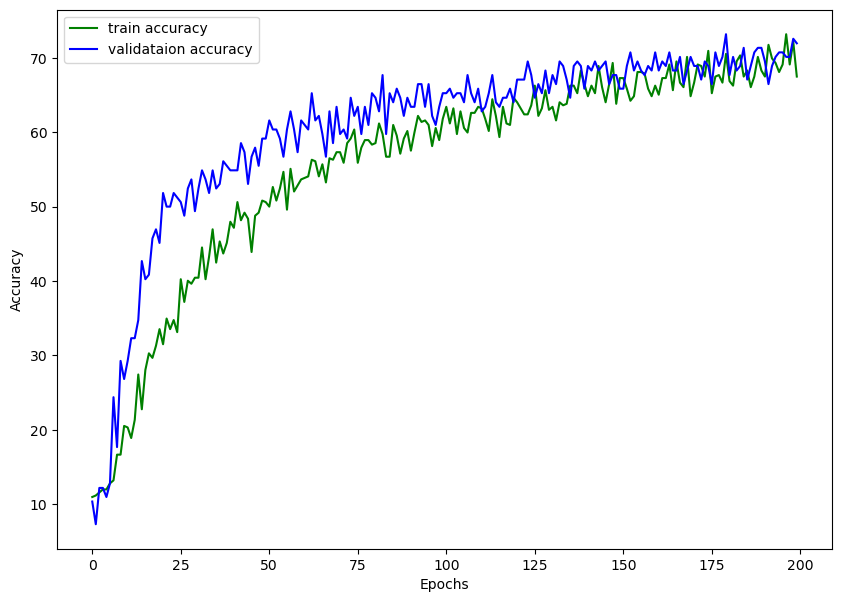

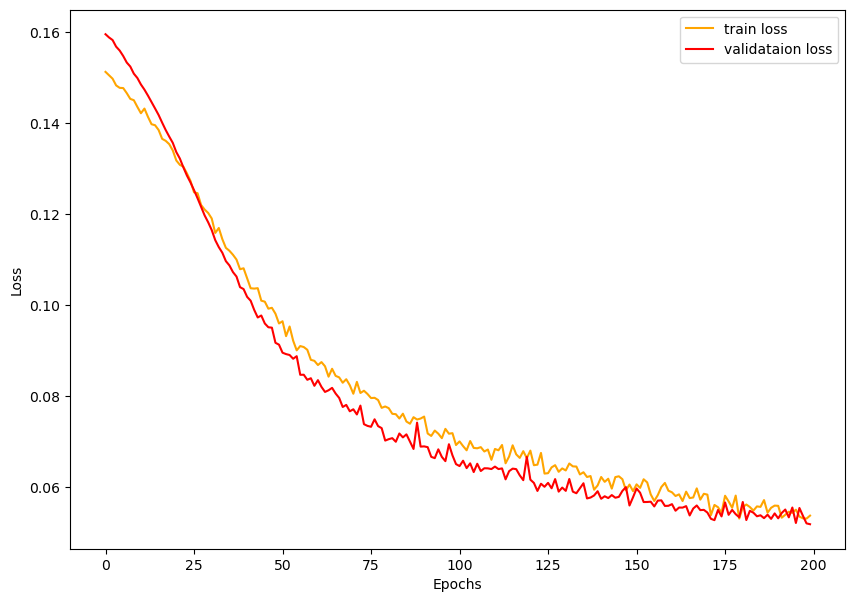

In [18]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_alex_200.jpg')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_alex_200.jpg')
plt.show()

In [19]:
class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(class_correct)
print(class_total)
print(sum(class_correct)/sum(class_total))
for i in range(11):
    print('Accuracy of %5s : %2d %%' % (
        vows[i], 100 * class_correct[i] / class_total[i]))

<ipython-input-8-e84cceec4aa6>:43: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)


[20.0, 10.0, 11.0, 11.0, 7.0, 9.0, 11.0, 5.0, 11.0, 4.0, 19.0]
[23.0, 16.0, 16.0, 11.0, 12.0, 15.0, 14.0, 9.0, 14.0, 13.0, 21.0]
0.7195121951219512
Accuracy of   cbf : 86 %
Accuracy of   ccf : 62 %
Accuracy of   cff : 68 %
Accuracy of  cmbf : 100 %
Accuracy of  cmcf : 58 %
Accuracy of  cmff : 60 %
Accuracy of   obf : 78 %
Accuracy of   off : 55 %
Accuracy of  ombf : 78 %
Accuracy of  omcf : 30 %
Accuracy of  omff : 90 %
